In [1]:
pip install librosa soundfile numpy pandas matplotlib tensorflow scikit-learn


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.3/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB 2.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import warnings
warnings.filterwarnings('ignore')


In [ ]:
## 1. Import Libraries

In [2]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


In [ ]:
## 2. Load and Process Audio Files

In [3]:
metadata = pd.read_csv(r"C:\Users\KASIREDDY HARSHINI\Downloads\UrbanSound8K\UrbanSound8K\metadata\UrbanSound8K.csv")
print(metadata.head())


      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


In [4]:
metadata.shape

(8732, 8)

In [5]:
metadata.info

<bound method DataFrame.info of          slice_file_name    fsID       start         end  salience  fold  \
0       100032-3-0-0.wav  100032    0.000000    0.317551         1     5   
1     100263-2-0-117.wav  100263   58.500000   62.500000         1     5   
2     100263-2-0-121.wav  100263   60.500000   64.500000         1     5   
3     100263-2-0-126.wav  100263   63.000000   67.000000         1     5   
4     100263-2-0-137.wav  100263   68.500000   72.500000         1     5   
...                  ...     ...         ...         ...       ...   ...   
8727     99812-1-2-0.wav   99812  159.522205  163.522205         2     7   
8728     99812-1-3-0.wav   99812  181.142431  183.284976         2     7   
8729     99812-1-4-0.wav   99812  242.691902  246.197885         2     7   
8730     99812-1-5-0.wav   99812  253.209850  255.741948         2     7   
8731     99812-1-6-0.wav   99812  332.289233  334.821332         2     7   

      classID             class  
0           3        

In [6]:
metadata.isnull().sum()

slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64

In [ ]:
## 3. Extract MFCC Features

In [7]:
def extract_features(file_path, n_mfcc=40, include_deltas=True, visualize=False):
    try:
        # Load audio
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        
        # Compute MFCCs
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        
        # Include delta and delta-delta (if True)
        if include_deltas:
            delta = librosa.feature.delta(mfcc)
            delta2 = librosa.feature.delta(mfcc, order=2)
            combined = np.vstack([mfcc, delta, delta2])  # Shape: (n_mfcc*3, time_steps)
        else:
            combined = mfcc
        
        # Take the mean across time to get a fixed-size feature vector
        features = np.mean(combined.T, axis=0)

        # Optional visualization
        if visualize:
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(mfcc, x_axis='time', sr=sample_rate)
            plt.colorbar()
            plt.title('MFCC')
            plt.tight_layout()
            plt.show()

        return features
    
    except Exception as e:
        print(f"Error processing file: {file_path}\n{e}")
        return None


In [8]:
def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled = np.mean(mfccs.T, axis=0)  # average over time
    return mfccs_scaled


In [9]:

import librosa

# ✅ Correct base directory
base_dir = r"C:\Users\KASIREDDY HARSHINI\Downloads\UrbanSound8K\UrbanSound8K"

# ✅ Set correct audio path
audio_path = os.path.join(base_dir, "audio")

# ✅ Example file path
metadata['file_path'] = metadata.apply(
    lambda row: os.path.join(audio_path, f"fold{row['fold']}", row['slice_file_name']),
    axis=1
)



In [10]:
import os

metadata['file_path'] = metadata.apply(
    lambda row: os.path.join(r"C:\Users\KASIREDDY HARSHINI\Downloads\UrbanSound8K\UrbanSound8K\audio", f"fold{row['fold']}", row['slice_file_name']),
    axis=1
)

metadata = metadata.reset_index(drop=True)
print("After filtering, total valid audio files:", len(metadata))


After filtering, total valid audio files: 8732


In [11]:
features = []
labels = []

for i, row in metadata.iterrows():
    file_path = row['file_path']
    class_label = row['classID']
    try:
        audio, sample_rate = librosa.load(file_path, res_type='polyphase')

        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfcc_processed = np.mean(mfcc.T, axis=0)
        features.append(mfcc_processed)
        labels.append(class_label)
    except Exception as e:
        print(f"Error with file: {file_path} \n {e}")


In [12]:

print("Labels length:", len(labels))
print("Features length:", len(features))
X = np.array(features)
y = to_categorical(np.array(labels))


Labels length: 8732
Features length: 8732


In [ ]:
## 4. Build CNN Model

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
model = Sequential()

model.add(Conv1D(64, 5, padding='same', input_shape=(40, 1)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=8))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D

model = Sequential()

model.add(Conv1D(64, 5, padding='same', input_shape=(40, 1)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=8))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')


In [17]:
## 5. Train the Model

In [18]:
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]


In [19]:
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.1286 - loss: 7.3964 - val_accuracy: 0.1305 - val_loss: 2.2809
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1503 - loss: 2.2684 - val_accuracy: 0.2278 - val_loss: 2.1372
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1874 - loss: 2.1852 - val_accuracy: 0.3068 - val_loss: 2.0117
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2150 - loss: 2.1038 - val_accuracy: 0.3097 - val_loss: 1.9515
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2170 - loss: 2.0528 - val_accuracy: 0.3320 - val_loss: 1.8763
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2357 - loss: 2.0114 - val_accuracy: 0.2942 - val_loss: 1.8406
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2338 - loss: 1.9920 - val_accuracy: 0.3492 - val_loss: 1.7992
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2573 - loss: 1.9533 - val_accu

In [20]:
## 6. Evaluate Model

In [21]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6386 - loss: 1.1043
Test Accuracy: 0.6433886885643005


In [22]:
import numpy as np

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes))


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.53      0.67      0.59       203
           1       0.77      0.69      0.72        86
           2       0.59      0.56      0.58       183
           3       0.68      0.66      0.67       201
           4       0.69      0.53      0.60       206
           5       0.66      0.64      0.65       193
           6       0.92      0.50      0.65        72
           7       0.63      0.88      0.73       208
           8       0.67      0.89      0.76       165
           9       0.66      0.42      0.51       230

    accuracy                           0.64      1747
   macro avg       0.68      0.64      0.65      1747
weighted avg       0.65      0.64      0.64      1747



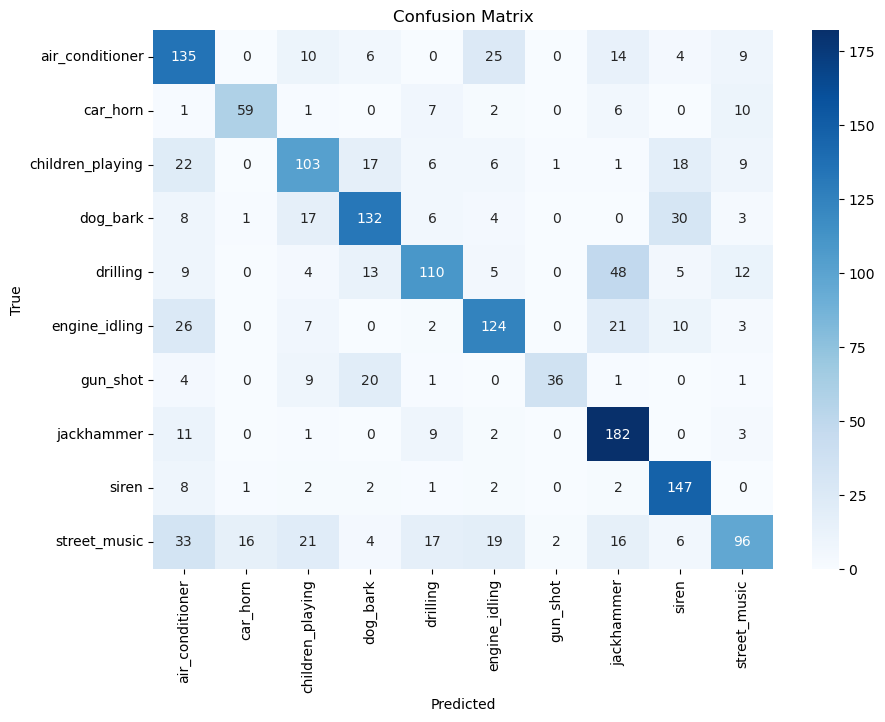

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define class names
class_names = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling',
               'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
